Missing synthetic file for ctabgan. Skipping.
Missing synthetic file for rtf. Skipping.


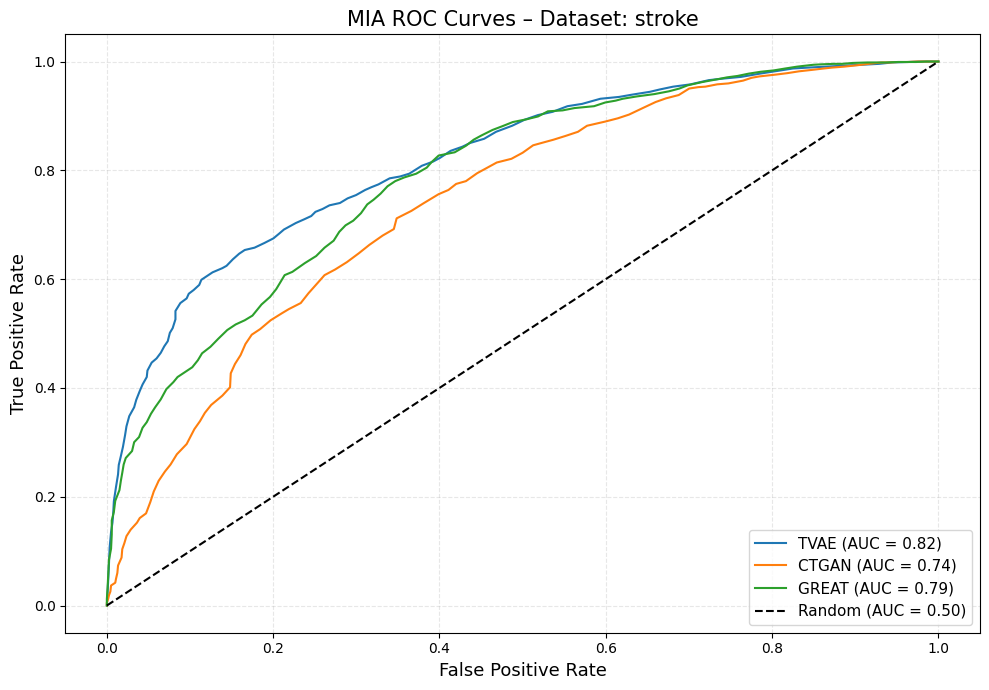


Membership Inference AUC Scores:
TVAE    : AUC = 0.821
CTGAN   : AUC = 0.742
GREAT   : AUC = 0.792


In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc

# 1. User Parameters
dataset_name = "stroke"
generators = ["tvae", "ctgan", "ctabgan", "great", "rtf"]  
# 2. Paths
real_path = f"../data/processed/{dataset_name}_train.csv"
test_path = f"../data/processed/{dataset_name}_test.csv"  # not used here
real_df_base = pd.read_csv(real_path)


plt.figure(figsize=(10, 7))
mia_scores = {}

# 3. Loop over generators
for generator_name in generators:
    synth_path = f"../data/synthetic/{generator_name}/{dataset_name}_{generator_name}.csv"
    if not os.path.exists(synth_path):
        print(f"Missing synthetic file for {generator_name}. Skipping.")
        continue

    synth_df_base = pd.read_csv(synth_path)
    real_df = real_df_base.copy()
    synth_df = synth_df_base.copy()
    
    categorical_cols = real_df.select_dtypes(include=['object', 'category']).columns.tolist()
    categorical_cols = [
        col for col in real_df.select_dtypes(include=['object', 'category']).columns
        if real_df[col].nunique() <= 20
    ]


    # --- One-hot encoding for categorical columns ---
    combined = pd.concat([real_df, synth_df], axis=0)
    encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    encoded = encoder.fit_transform(combined[categorical_cols])
    encoded_cols = encoder.get_feature_names_out(categorical_cols)

    real_encoded = pd.DataFrame(encoded[:len(real_df)], columns=encoded_cols, index=real_df.index)
    synth_encoded = pd.DataFrame(encoded[len(real_df):], columns=encoded_cols, index=synth_df.index)

    real_df = real_df.drop(columns=categorical_cols).join(real_encoded)
    synth_df = synth_df.drop(columns=categorical_cols).join(synth_encoded)

    # --- MIA labels ---
    y_member = np.ones(len(real_df))
    y_nonmember = np.zeros(len(synth_df))

    X = pd.concat([real_df, synth_df], axis=0)
    y = np.concatenate([y_member, y_nonmember])

    # --- Train/test split and attack model ---
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)

    probs = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)


    mia_scores[generator_name] = roc_auc
    plt.plot(fpr, tpr, label=f"{generator_name.upper()} (AUC = {roc_auc:.2f})")


plt.plot([0, 1], [0, 1], 'k--', label="Random (AUC = 0.50)")
plt.xlabel("False Positive Rate", fontsize=13)
plt.ylabel("True Positive Rate", fontsize=13)
plt.title(f"MIA ROC Curves – Dataset: {dataset_name}", fontsize=15)
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

# Print AUCs
print("\nMembership Inference AUC Scores:")
for model, score in mia_scores.items():
    print(f"{model.upper():8s}: AUC = {score:.3f}")
